<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

<h1>1. Business Problem</h1>

<h2>1.1. Description</h2>

<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p>
<p> Data: Memorial Sloan Kettering Cancer Center (MSKCC)</p>
<p> Download training_variants.zip and training_text.zip from Kaggle.</p> 

<h6> Context:</h6>
<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462</p>

<h6> Problem statement : </h6>
<p> Classify the given genetic variations/mutations based on evidence from text-based clinical literature. </p>

<h1>2. Machine Learning Problem Formulation</h1>

<h2>2.1. Data</h2>

<h3>2.1.1. Data Overview</h3>

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

<h3>2.1.2. Example Data Point</h3>

<h6>training_variants</h6>
<hr>
ID,Gene,Variation,Class<br>
0,FAM58A,Truncating Mutations,1 <br>
1,CBL,W802*,2 <br>
2,CBL,Q249E,2 <br>
...

<h6> training_text</h6>
<hr>
ID,Text <br>
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10 silencing in increasing c-Raf and in conferring tamoxifen resistance to breast cancer cells. CDK10/cyclin M phosphorylates ETS2 in vitro, and in cells it positively controls ETS2 degradation by the proteasome. ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels. Altogether, our results reveal an additional regulatory mechanism for ETS2, which plays key roles in cancer and development. They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1). The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2). Although discovered almost 20 y ago (3, 4), CDK10 remains one of the two CDKs without an identified cyclin partner. This knowledge gap has largely impeded the exploration of its biological functions. CDK10 can act as a positive cell cycle regulator in some cells (5, 6) or as a tumor suppressor in others (7, 8). CDK10 interacts with the ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2) transcription factor and inhibits its transcriptional activity through an unknown mechanism (9). CDK10 knockdown derepresses ETS2, which increases the expression of the c-Raf protein kinase, activates the MAPK pathway, and induces resistance of MCF7 cells to tamoxifen (6). ... 

<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<h3>2.2.1. Type of Machine Learning Problem</h3>

<p>
    
            There are nine different classes a genetic mutation can be classified into => Multi class classification problem
   
      
    
</p>

<h3>2.2.2. Performance Metric</h3>

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation

Metric(s): 
* Multi class log-loss 
* Confusion matrix 


<h2>2.3. Train, CV and Test Datasets</h2>

 Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

<h1>3. Exploratory Data Analysis</h1>

In [4]:
import re
import time
import math
import nltk
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

<h2>3.1. Reading Data</h2>

<h3>3.1.1. Reading Gene and Variation Data</h3>

In [6]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

<h3>3.1.2. Reading Text Data</h3>

In [7]:
# note the seprator in this file
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1,)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3>3.1.3. Preprocessing of text</h3>

In [8]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [9]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    nlp_preprocessing(row['TEXT'], index, 'TEXT')
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

/opt/conda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Time took for preprocessing the text : 128.99371 seconds


In [10]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


<h3>3.1.4. Test, Train and Cross Validation Split</h3>

<h4>3.1.4.1. Splitting data into train, test and cross validation (64:20:16)</h4>

In [11]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train_df, X_test, y_train_df, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train_df, y_train_df, stratify=y_train_df, test_size=0.2)

<p> We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set  </p>

In [12]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])
print('Number of data points in test data:', X_test.shape[0])

Number of data points in train data: 2124
Number of data points in cross validation data: 532
Number of data points in test data: 665


<h4>3.1.4.2. Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

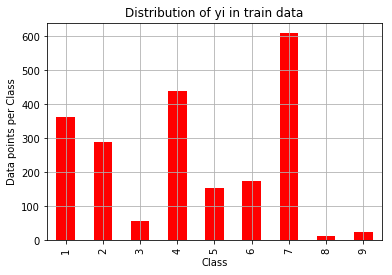

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


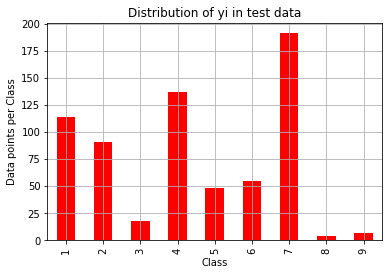

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


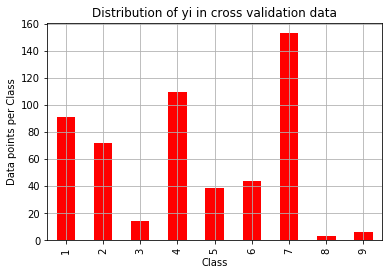

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [13]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = X_train['Class'].value_counts().sort_index()
test_class_distribution = X_test['Class'].value_counts().sort_index()
cv_class_distribution = X_cv['Class'].value_counts().sort_index()


my_colors = ['r','g','b','k','y','m','c']
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/X_train.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = ['r','g','b','k','y','m','c']
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/X_test.shape[0]*100), 3), '%)')

    
    
my_colors = ['r','g','b','k','y','m','c']
cv_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/X_cv.shape[0]*100), 3), '%)')
    
    
    

<h2>3.2 Univariate Gene Analysis</h2>

In [14]:
unique_genes = X_train['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 237
BRCA1     178
TP53       99
EGFR       98
PTEN       78
BRCA2      70
BRAF       59
ERBB2      51
KIT        50
ALK        45
PDGFRA     41
Name: Gene, dtype: int64


In [15]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 237 different categories of genes in the train data, and they are distibuted as follows


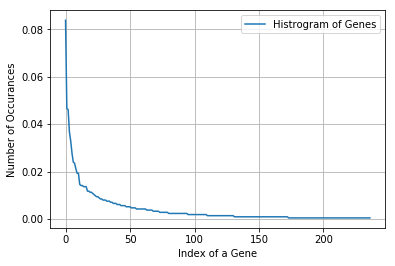

In [16]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


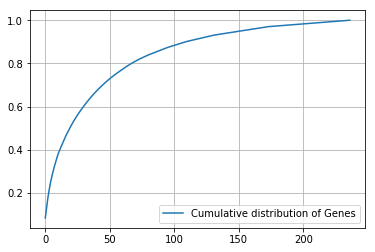

In [17]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [18]:
# bow encoding of Gene feature using Tfidf vectorizer.
gene_vectorizer = CountVectorizer()
train_gene_feature_bow = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_bow = gene_vectorizer.transform(X_test['Gene'])
cv_gene_feature_bow = gene_vectorizer.transform(X_cv['Gene'])

In [19]:
# TF-IDF encoding of Gene feature using Tfidf vectorizer.
gene_vectorizer = TfidfVectorizer()
train_gene_feature_tfidf = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_tfidf = gene_vectorizer.transform(X_test['Gene'])
cv_gene_feature_tfidf = gene_vectorizer.transform(X_cv['Gene'])

In [20]:
X_train['Gene'].head()

2888     BRCA2
1350      AKT1
908     PDGFRA
3277       RET
2946       KDR
Name: Gene, dtype: object

In [21]:
print("train_gene_feature_bow is converted feature using Bag of Words encoding method. The shape of gene feature:", train_gene_feature_bow.shape)

train_gene_feature_bow is converted feature using Bag of Words encoding method. The shape of gene feature: (2124, 237)


In [22]:
print("train_gene_feature_tfidf is converted feature using Bag of Words encoding method. The shape of gene feature:", train_gene_feature_tfidf.shape)

train_gene_feature_tfidf is converted feature using Bag of Words encoding method. The shape of gene feature: (2124, 237)


<h2>3.3 Univariate Analysis on Variation Feature</h2>

In [23]:
unique_variations =X_train['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1917
Truncating_Mutations    63
Deletion                52
Amplification           45
Fusions                 22
Overexpression           3
T58I                     3
G12V                     3
F28L                     2
ETV6-NTRK3_Fusion        2
G13C                     2
Name: Variation, dtype: int64


In [24]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1917 different categories of variations in the train data, and they are distibuted as follows


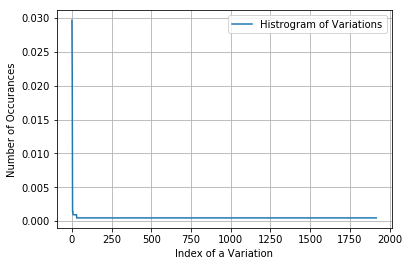

In [25]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[ 0.02966102  0.05414313  0.07532957 ...,  0.99905838  0.99952919  1.        ]


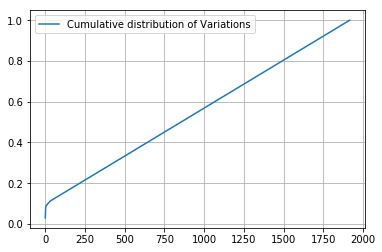

In [26]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [27]:
# Bag of words encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_bow = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_bow = variation_vectorizer.transform(X_test['Variation'])
cv_variation_feature_bow = variation_vectorizer.transform(X_cv['Variation'])

In [28]:
# TF-IDF encoding of variation feature.
variation_vectorizer = TfidfVectorizer()
train_variation_feature_tfidf = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_tfidf = variation_vectorizer.transform(X_test['Variation'])
cv_variation_feature_tfidf = variation_vectorizer.transform(X_cv['Variation'])

In [29]:
print("train_variation_feature_bow is converted feature using the bow encoding method. The shape of Variation feature:", train_variation_feature_bow.shape)

train_variation_feature_bow is converted feature using the bow encoding method. The shape of Variation feature: (2124, 1951)


In [30]:
print("train_variation_feature_tfidf is converted feature using the tfidf encoding method. The shape of Variation feature:", train_variation_feature_tfidf.shape)

train_variation_feature_tfidf is converted feature using the tfidf encoding method. The shape of Variation feature: (2124, 1951)


<h2>3.4 Univariate Analysis on Text Feature</h2>

In [31]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_bow = text_vectorizer.fit_transform(X_train['TEXT'])
# don't forget to normalize every feature
train_text_feature_bow = normalize(train_text_feature_bow, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_bow = text_vectorizer.transform(X_test['TEXT'])
# don't forget to normalize every feature
test_text_feature_bow = normalize(test_text_feature_bow, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_bow = text_vectorizer.transform(X_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature_bow = normalize(cv_text_feature_bow, axis=0)


In [32]:
# building a TfidfVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_tfidf = text_vectorizer.fit_transform(X_train['TEXT'])
# don't forget to normalize every feature
train_text_feature_tfidf = normalize(train_text_feature_tfidf, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_tfidf = text_vectorizer.transform(X_test['TEXT'])
# don't forget to normalize every feature
test_text_feature_tfidf = normalize(test_text_feature_tfidf, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_tfidf = text_vectorizer.transform(X_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature_tfidf = normalize(cv_text_feature_tfidf, axis=0)


 <h2>3.5 Stacking the three types of features </h2>

In [33]:
train_gene_var_bow = hstack((train_gene_feature_bow,train_variation_feature_bow))
test_gene_var_bow = hstack((test_gene_feature_bow,test_variation_feature_bow))
cv_gene_var_bow = hstack((cv_gene_feature_bow,cv_variation_feature_bow))

train_x_bow = hstack((train_gene_var_bow, train_text_feature_bow)).tocsr()
test_x_bow = hstack((test_gene_var_bow, test_text_feature_bow)).tocsr()
cv_x_bow = hstack((cv_gene_var_bow, cv_text_feature_bow)).tocsr()


In [34]:
train_gene_var_tfidf = hstack((train_gene_feature_tfidf,train_variation_feature_tfidf))
test_gene_var_tfidf = hstack((test_gene_feature_tfidf,test_variation_feature_tfidf))
cv_gene_var_tfidf = hstack((cv_gene_feature_tfidf,cv_variation_feature_tfidf))

train_x_tfidf = hstack((train_gene_var_tfidf, train_text_feature_tfidf)).tocsr()
test_x_tfidf = hstack((test_gene_var_tfidf, test_text_feature_tfidf)).tocsr()
cv_x_tfidf = hstack((cv_gene_var_tfidf, cv_text_feature_tfidf)).tocsr()


<h2> 3.6 User-Defined Function </h2>

In [35]:
#Misc. functionns for ML models
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

<h1>4. Machine Learning Models</h1>

<h2> 4.1 Random Model </h2>

Log loss on Cross Validation Data using Random Model 2.48197282776
Log loss on Test Data using Random Model 2.50004043095
-------------------- Confusion matrix --------------------


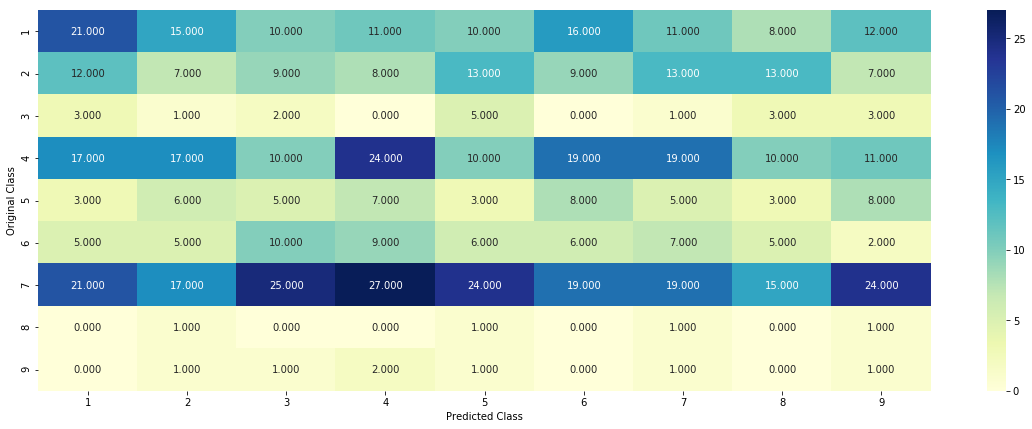

-------------------- Precision matrix (Columm Sum=1) --------------------


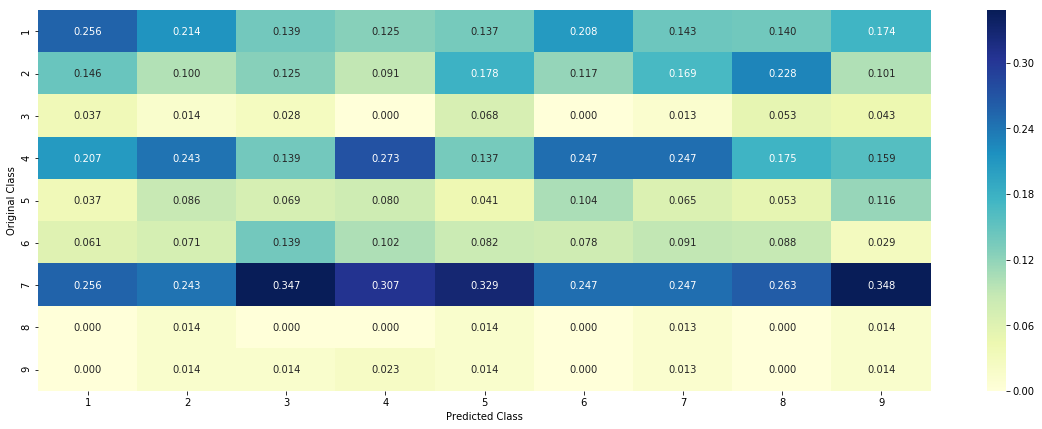

-------------------- Recall matrix (Row sum=1) --------------------


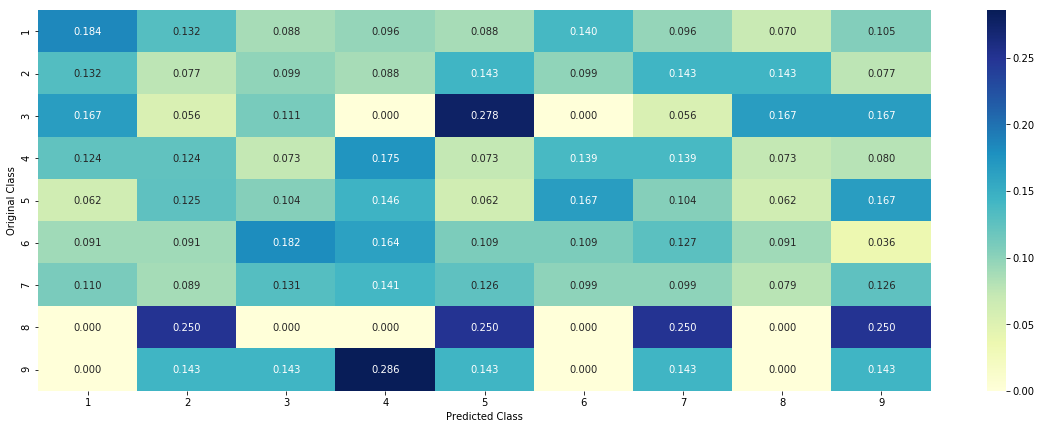

In [37]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

<h2>4.2 Logistic Regression</h2>

<h3>4.2.1. With Class balancing on Bag of Words </h3>

<h4>Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.75161184465
for alpha = 1e-05
Log Loss : 1.75062636666
for alpha = 0.0001
Log Loss : 1.7407226443
for alpha = 0.001
Log Loss : 1.62724068735
for alpha = 0.01
Log Loss : 1.22924458642
for alpha = 0.1
Log Loss : 1.12513135666
for alpha = 1
Log Loss : 1.11791548881
for alpha = 10
Log Loss : 1.12760036844
for alpha = 100
Log Loss : 1.13147203405


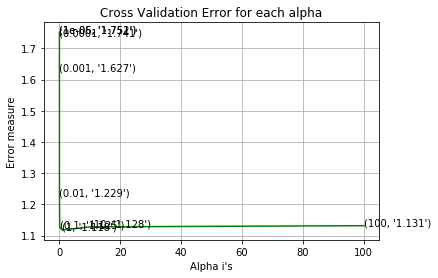

For values of best alpha =  1 The train log loss is: 0.532663018187
For values of best alpha =  1 The cross validation log loss is: 1.11791548881
For values of best alpha =  1 The test log loss is: 1.03572218818


In [38]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf=LogisticRegression(class_weight='balanced',C=i,random_state=42)
    clf.fit(train_x_bow, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_bow, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_bow)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf=LogisticRegression(class_weight='balanced',C=alpha[best_alpha],random_state=42)
clf.fit(train_x_bow,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_bow, y_train)

predict_y = sig_clf.predict_proba(train_x_bow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>Testing the model with best hyper paramters</h4>

Log loss : 1.03572218818
Number of mis-classified points : 0.3263157894736842
-------------------- Confusion matrix --------------------


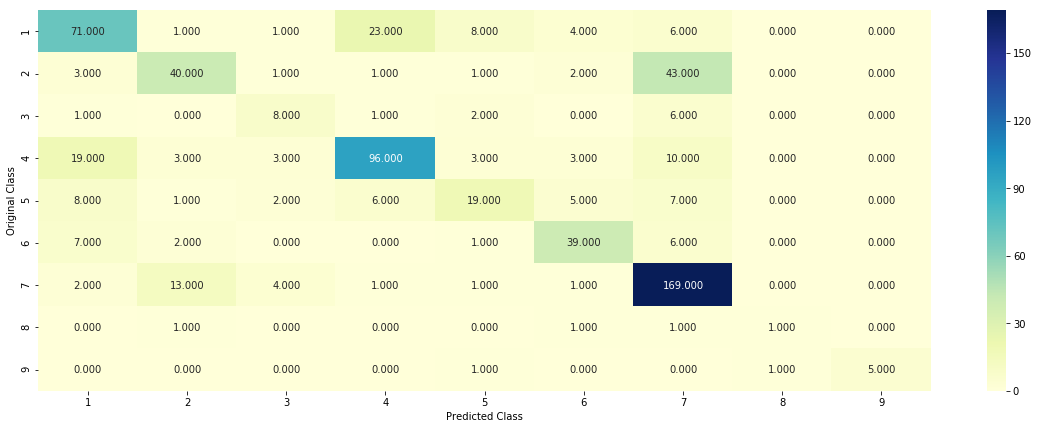

-------------------- Precision matrix (Columm Sum=1) --------------------


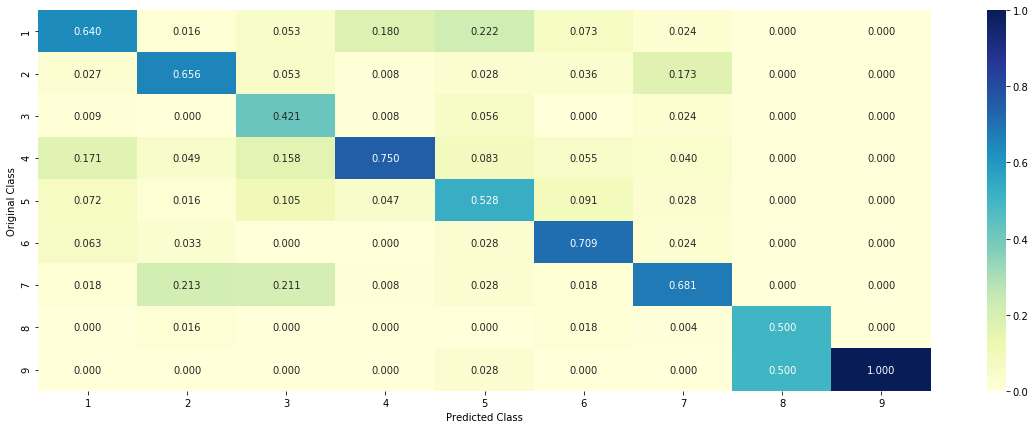

-------------------- Recall matrix (Row sum=1) --------------------


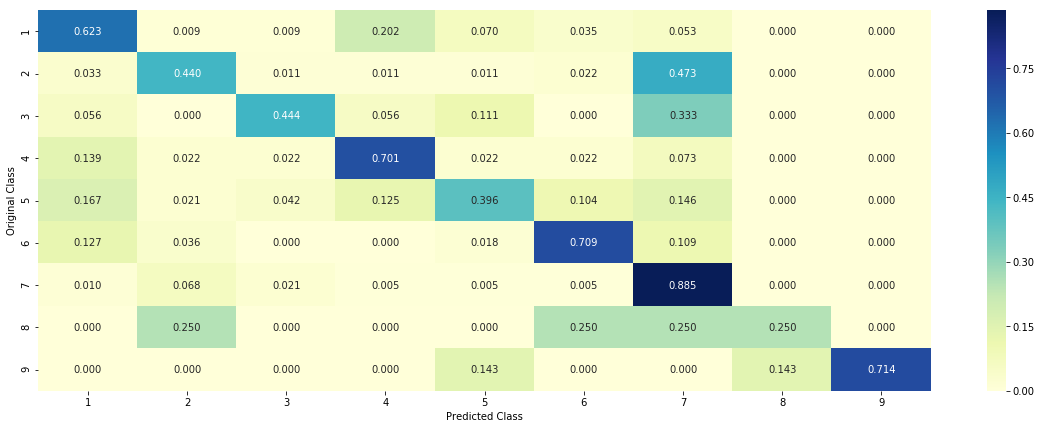

In [39]:
clf=LogisticRegression(class_weight='balanced',C=alpha[best_alpha],random_state=42)
predict_and_plot_confusion_matrix(train_x_bow, y_train, test_x_bow, y_test, clf)

<h3>4.2.2 With Class Balancing for TF-IDF </h3>

<h4> Hyper Parameter Tunning </h4>

for alpha = 1e-06
Log Loss : 1.50035457663
for alpha = 1e-05
Log Loss : 1.4988675175
for alpha = 0.0001
Log Loss : 1.48441933174
for alpha = 0.001
Log Loss : 1.37919783449
for alpha = 0.01
Log Loss : 1.21561004602
for alpha = 0.1
Log Loss : 1.09233066296
for alpha = 1
Log Loss : 1.07955836727
for alpha = 10
Log Loss : 1.09413289744
for alpha = 100
Log Loss : 1.10821515687


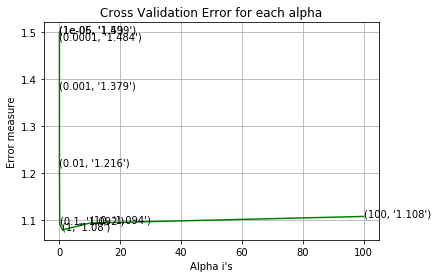

For values of best alpha =  1 The train log loss is: 0.509200492695
For values of best alpha =  1 The cross validation log loss is: 1.07955836727
For values of best alpha =  1 The test log loss is: 0.997537489301


In [40]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf=LogisticRegression(class_weight='balanced',C=i,random_state=42)
    clf.fit(train_x_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf=LogisticRegression(class_weight='balanced',C=alpha[best_alpha],random_state=42)
clf.fit(train_x_tfidf,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, y_train)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4> Testing the models with Best Hyperparameters </h4>

Log loss : 0.997537489301
Number of mis-classified points : 0.3233082706766917
-------------------- Confusion matrix --------------------


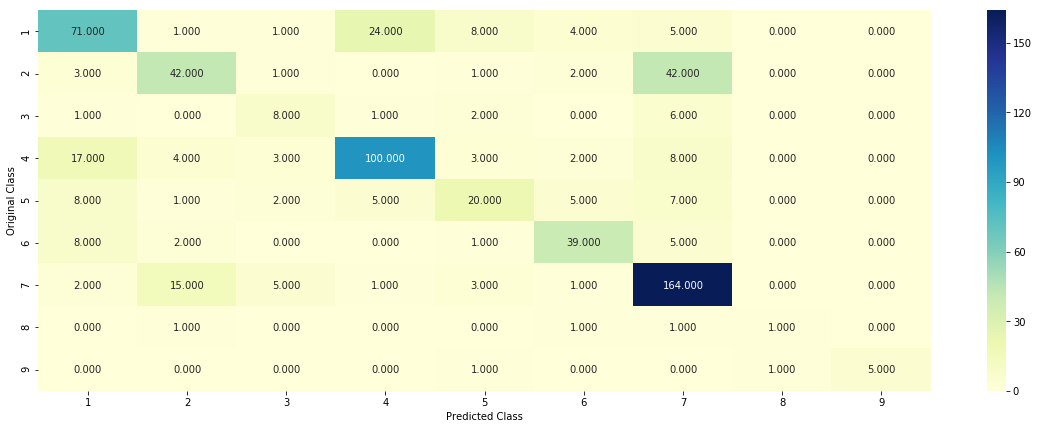

-------------------- Precision matrix (Columm Sum=1) --------------------


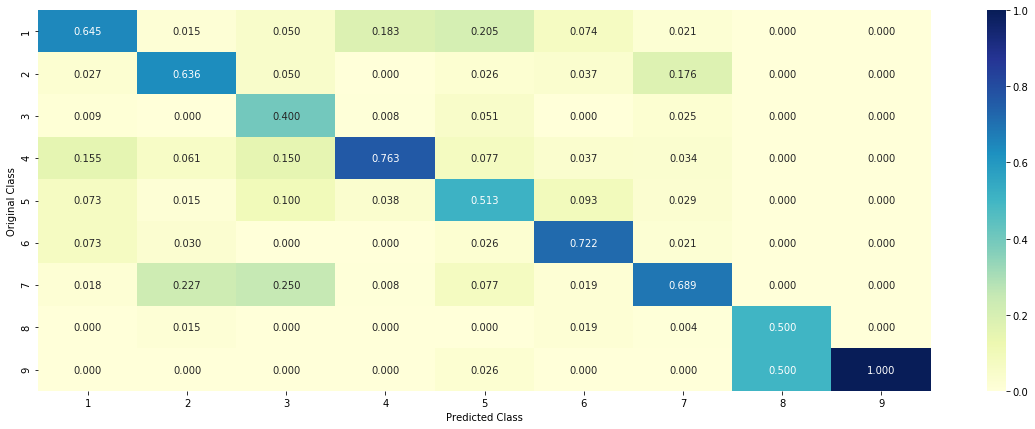

-------------------- Recall matrix (Row sum=1) --------------------


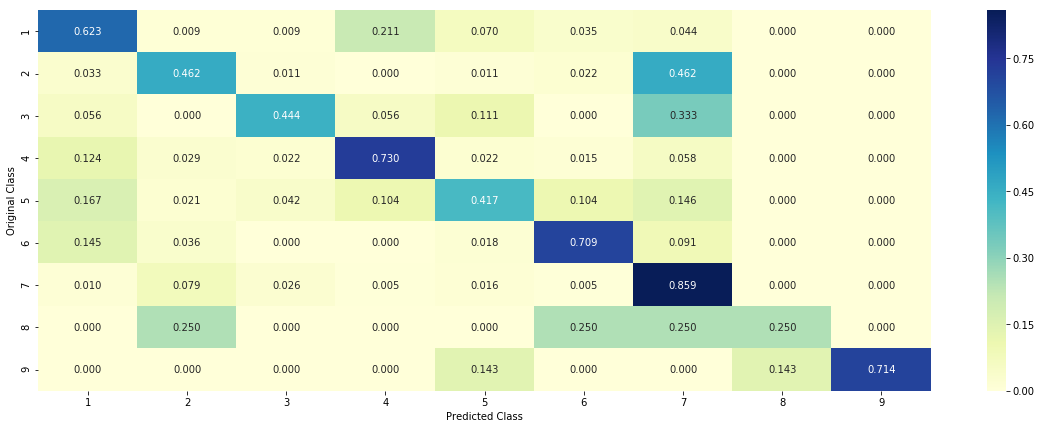

In [41]:
clf=LogisticRegression(class_weight='balanced',C=alpha[best_alpha],random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf, y_train, test_x_tfidf, y_test, clf)

<h2> 5.0 Conclusion </h2>

Data Processing and Cleaning was done.  
Data contained three features which are categorical in Nature:
    1. Gene
    2. Variations
    3. Text

All this features were converted to vectors using Bag of Words and TF-IDF vector representation.Logistic Regression was used to model the data. 

<table style="width:100%">
  <tr>
    <th>Vectorizer</th>
    <th>Train Loss</th> 
    <th>Cross Validation loss</th>
    <th>Test Loss</th> 
    <th>% Misclassified points</th>
  </tr>
  <tr>
    <td>Bag of Words</td> 
    <td>0.5326</td>
    <td>1.1179</td> 
    <td>1.0357</td>
    <td>32.63</td> 
  </tr>
  <tr>
    <td>TF-IDF</td>
    <td>0.5092</td> 
    <td>1.0795</td>
    <td>0.9975</td> 
    <td>32.33</td> 
  </tr>
</table>